In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model, tree, ensemble, svm
import xgboost
print(xgboost.__version__)

3.0.1


In [2]:
data=pd.read_csv(r"C:\TrafficTelligence\traffic volume.csv")

In [3]:
data.head()

,holiday,temp,rain,snow,weather,date,Time,traffic_volume
0,7,288.28,0.0,0.0,1.0,02-10-2012,09:00:00,5545
1,7,289.36,0.0,0.0,1.0,02-10-2012,10:00:00,4516
2,7,289.58,0.0,0.0,1.0,02-10-2012,11:00:00,4767
3,7,290.13,0.0,0.0,1.0,02-10-2012,12:00:00,5026
4,7,291.14,0.0,0.0,1.0,02-10-2012,13:00:00,4918


In [4]:
data.describe()

,holiday,temp,rain,snow,weather,traffic_volume
count,48204.000000,48151.000000,48202.000000,48192.000000,48155.000000,48204.000000
mean,6.997780,281.205351,0.334278,0.000222,2.578299,3259.818355
std,0.139999,13.343675,44.790062,0.008169,2.784449,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,272.160000,0.000000,0.000000,0.000000,1193.000000
50%,7.000000,282.460000,0.000000,0.000000,1.000000,3380.000000
75%,7.000000,291.810000,0.000000,0.000000,5.000000,4933.000000
max,11.000000,310.070000,9831.300000,0.510000,10.000000,7280.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  int64  
 1   temp            48151 non-null  float64
 2   rain            48202 non-null  float64
 3   snow            48192 non-null  float64
 4   weather         48155 non-null  float64
 5   date            48204 non-null  object 
 6   Time            48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 2.9+ MB


In [6]:
data.isnull().sum()

holiday            0
temp              53
rain               2
snow              12
weather           49
date               0
Time               0
traffic_volume     0
dtype: int64

In [7]:
from collections import Counter
data.fillna({'temp': data['temp'].mean()}, inplace=True)
data.fillna({'rain': data['rain'].mean()}, inplace=True)
data.fillna({'snow': data['snow'].mean()}, inplace=True)
print(Counter(data['weather']))
data['weather']=data['weather'].fillna('Clouds')

Counter({1.0: 15144, 0.0: 13383, 5.0: 5942, 6.0: 5665, 8.0: 2875, 2.0: 1818, 4.0: 1359, 10.0: 1033, 3.0: 912, 7.0: 20, 9.0: 4, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1, nan: 1})


<Axes: >

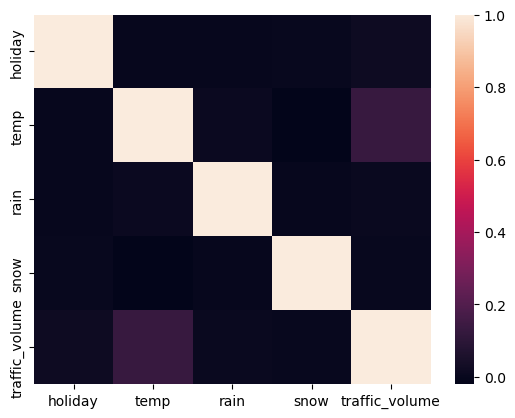

In [8]:
# Calculate correlation only for numerical columns
sns.heatmap(data.corr(numeric_only=True))

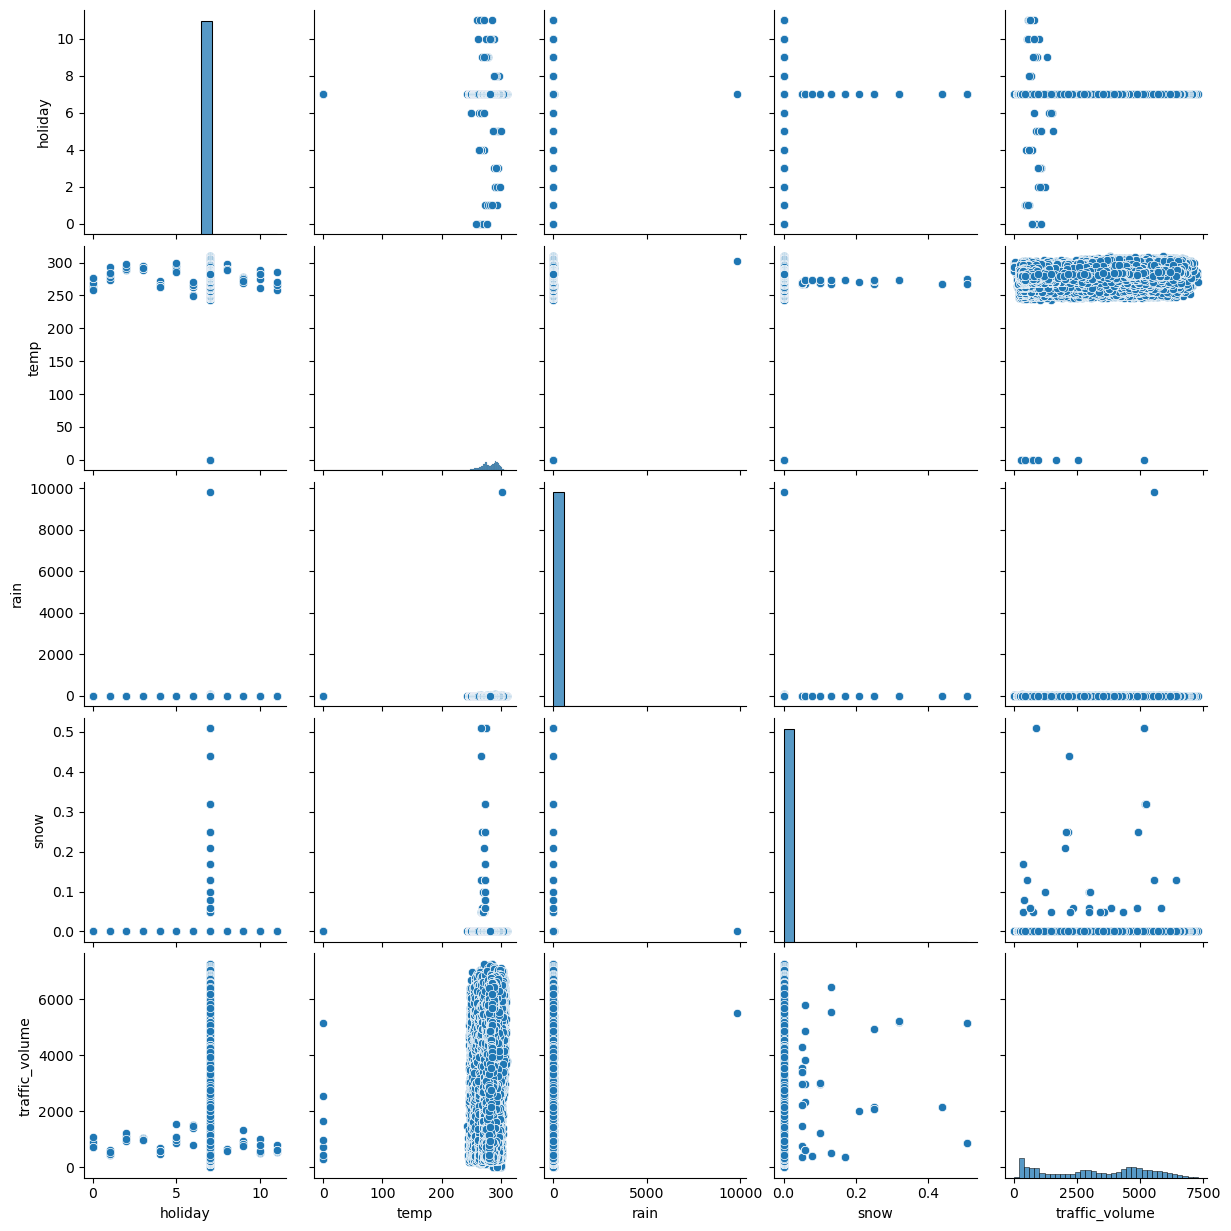

In [9]:
sns.pairplot(data)

<Axes: >

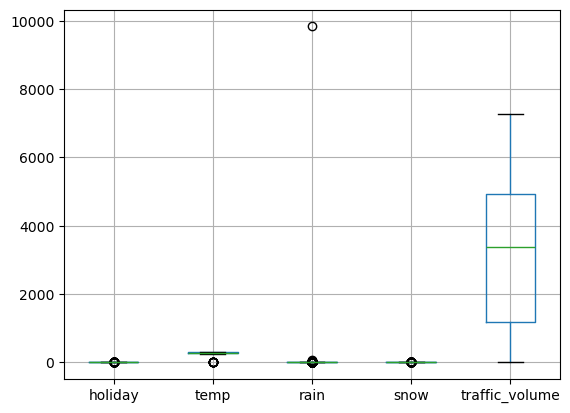

In [10]:
data.boxplot()

In [11]:
data[["day","month","year"]]=data["date"].str.split("-",expand=True)
data[["hours","minutes","seconds"]]=data["Time"].str.split(":",expand=True)
data.drop(columns=['date','Time'],axis=1,inplace=True)
data.head()

,holiday,temp,rain,snow,weather,traffic_volume,day,month,year,hours,minutes,seconds
0,7,288.28,0.0,0.0,1.0,5545,02,10,2012,09,00,00
1,7,289.36,0.0,0.0,1.0,4516,02,10,2012,10,00,00
2,7,289.58,0.0,0.0,1.0,4767,02,10,2012,11,00,00
3,7,290.13,0.0,0.0,1.0,5026,02,10,2012,12,00,00
4,7,291.14,0.0,0.0,1.0,4918,02,10,2012,13,00,00


In [12]:
y=data['traffic_volume']
x=data.drop(columns=['traffic_volume'],axis=1)

In [13]:
names=x.columns

In [14]:
from sklearn.preprocessing import scale

In [15]:
# Check the data types of the columns in x
print(x.dtypes)

# You will likely see 'object' or 'string' dtypes for 'holiday' and 'weather'
# We need to one-hot encode these categorical columns

# Import the necessary function for one-hot encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify categorical columns (assuming 'holiday' and 'weather' are the only ones)
categorical_features = ['holiday', 'weather']
numerical_features = x.columns.difference(categorical_features).tolist()

# --- Add this section to inspect and clean categorical columns ---
print("\nChecking unique values and types in categorical columns:")
for col in categorical_features:
    print(f"Column '{col}':")
    unique_values = x[col].unique()
    print(f"  Unique values: {unique_values[:10]}...") # Print a sample of unique values
    print(f"  Value types: {[type(val) for val in unique_values[:10]]}...") # Print types of sample values

# Ensure categorical columns are of string type
for col in categorical_features:
    # Convert to string, converting any non-string/non-NaN values to their string representation
    x[col] = x[col].astype(str)
# --- End of added section ---


# Create a column transformer to apply one-hot encoding to categorical features
# and pass through numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features) # handle_unknown='ignore' is useful for unseen categories during testing
    ])

# Apply the preprocessing
x_processed = preprocessor.fit_transform(x)

# Now x_processed is a numpy array with the categorical columns one-hot encoded
# You can now apply the scale function to x_processed

from sklearn.preprocessing import scale

# Scale the processed data
x_scaled = scale(x_processed)

# You can now use x_scaled for your model training

holiday      int64
temp       float64
rain       float64
snow       float64
weather     object
day         object
month       object
year        object
hours       object
minutes     object
seconds     object
dtype: object

Checking unique values and types in categorical columns:
Column 'holiday':
  Unique values: [ 7  1 10  9  0  6 11  5  2  8]...
  Value types: [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]...
Column 'weather':
  Unique values: [1.0 0.0 6.0 2.0 5.0 4.0 'Clouds' 3.0 10.0 8.0]...
  Value types: [<class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'float'>, <class 'str'>, <class 'float'>, <class 'float'>, <class 'float'>]...


In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.2,random_state=0)

In [17]:
lin_reg=linear_model.LinearRegression()
Dtree=tree.DecisionTreeRegressor()
Rand=ensemble.RandomForestRegressor()
svr=svm.SVR()
XGB=xgboost.XGBRegressor()

In [ ]:
lin_reg.fit(x_train,y_train)
Dtree.fit(x_train,y_train)
Rand.fit(x_train,y_train)
svr.fit(x_train,y_train)
XGB.fit(x_train,y_train)

In [19]:
p1=lin_reg.predict(x_train)
p2=Dtree.predict(x_train)
p3=Rand.predict(x_train)
p4=svr.predict(x_train)
p5=XGB.predict(x_train)

In [20]:
from sklearn import metrics
print(metrics.r2_score(p1,y_train))
print(metrics.r2_score(p2,y_train))
print(metrics.r2_score(p3,y_train))
print(metrics.r2_score(p4,y_train))
print(metrics.r2_score(p5,y_train))

-4.983266849388355
1.0
0.9740234037141068
-35.74285269355318
0.8381707072257996


In [21]:
p1=lin_reg.predict(x_test)
p2=Dtree.predict(x_test)
p3=Rand.predict(x_test)
p4=svr.predict(x_test)
p5=XGB.predict(x_test)

In [22]:
print(metrics.r2_score(p1,y_test))
print(metrics.r2_score(p2,y_test))
print(metrics.r2_score(p3,y_test))
print(metrics.r2_score(p4,y_test))
print(metrics.r2_score(p5,y_test))

-4.852603948020568
0.687109873436724
0.7969015536923026
-34.9540031495395
0.8015495538711548


In [23]:
MSE=metrics.mean_squared_error(p3,y_test)
np.sqrt(MSE)

809.9968601537578

In [24]:
import pickle
pickle.dump(Rand,open('model.pkl','wb'))
pickle.dump(lin_reg,open('encoder.pkl','wb'))